In [79]:
!pip install --disable-pip-version-check -q awswrangler==2.14.0

In [80]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [199]:
import boto3
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
from sagemaker.transformer import Transformer
from pyathena import connect

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as cm
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc

import io
from time import gmtime, strftime, time
import re

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
prefix = 'olist_review_score'

s3 = boto3.resource('s3')
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3_client = boto3.client("s3", region_name=region)

## Store Data into S3 Data Lake ##

In [82]:
s3_source_path_csvs = "/root/OlistEcommerce/ProjectDataset/"
print(s3_source_path_csvs)

/root/OlistEcommerce/ProjectDataset/


In [83]:
s3_destination_path_csv = "s3://{}/FinalProjectDataset/csv".format(bucket)
print(s3_destination_path_csv)

s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv


In [84]:
!aws s3 cp $s3_source_path_csvs $s3_destination_path_csv/ --recursive --exclude "*" --include "*.csv"

upload: ProjectDataset/olist_order_payments_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_order_payments_dataset.csv
upload: ProjectDataset/product_category_name_translation.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/product_category_name_translation.csv
upload: ProjectDataset/olist_products_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_products_dataset.csv
upload: ProjectDataset/olist_customers_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_customers_dataset.csv
upload: ProjectDataset/olist_order_reviews_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_order_reviews_dataset.csv
upload: ProjectDataset/olist_geolocation_dataset1.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_geolocation_dataset1.csv
upload: ProjectDataset/olist_sellers_dataset.csv to s3://sagemaker-us-east-1-757088774357/Fina

In [85]:
# Confirm that all data was uploaded
!aws s3 ls $s3_destination_path_csv/

                           PRE /
2024-06-01 01:00:15    9033957 olist_customers_dataset.csv
2024-06-01 01:00:15   23400724 olist_geolocation_dataset1.csv
2024-06-01 01:00:15   23582346 olist_geolocation_dataset2.csv
2024-06-01 01:00:16   15438671 olist_order_items_dataset.csv
2024-06-01 01:00:15    5777138 olist_order_payments_dataset.csv
2024-06-01 01:00:15   14451670 olist_order_reviews_dataset.csv
2024-06-01 01:00:15   17654914 olist_orders_dataset.csv
2024-06-01 01:00:16    2379446 olist_products_dataset.csv
2024-06-01 01:00:15     174703 olist_sellers_dataset.csv
2024-06-01 01:00:15       2613 product_category_name_translation.csv


## Setup PyAthena ##

In [86]:
db_name = "olist_ecommerce_aws"

In [87]:
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
print(s3_staging_dir)

s3://sagemaker-us-east-1-757088774357/athena/staging


In [88]:
# Establish Connection to Athena Staging Directory in S3
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [89]:
# Create the Olist Ecommerce AWS DB if One Does not Exist
statement = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)
pd.read_sql(statement, conn)

""


In [90]:
# Ensure DB Now Exists or Already Existed
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,olist_ecommerce_aws
2,sagemaker_featurestore


### Create Table in PyAthena ###

In [91]:
### NOTE: Skipped for Now

## Perform EDA Using Data Lake ##

In [92]:
print(bucket)

sagemaker-us-east-1-757088774357


In [93]:
customer_data_object = s3_client.get_object(Bucket=bucket, Key=
    "FinalProjectDataset/csv/olist_customers_dataset.csv"
)
geolocation_data_object1 = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_geolocation_dataset1.csv"
))
geolocation_data_object2 = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_geolocation_dataset2.csv"
))
items_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_items_dataset.csv"
))
order_payments_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_payments_dataset.csv"
))
order_reviews_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_reviews_dataset.csv"
))
orders_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_orders_dataset.csv"
))
products_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_products_dataset.csv"
))
sellers_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_sellers_dataset.csv"
))
product_category_name_translation_data_object= s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/product_category_name_translation.csv"
))

customer_data = pd.read_csv(io.BytesIO(customer_data_object["Body"].read()))
geolocation_data1 = pd.read_csv(io.BytesIO(geolocation_data_object1["Body"].read()))
geolocation_data2 = pd.read_csv(io.BytesIO(geolocation_data_object2["Body"].read()))
order_items_data = pd.read_csv(io.BytesIO(items_data_object["Body"].read()))
order_payments_data = pd.read_csv(io.BytesIO(order_payments_data_object["Body"].read()))
order_reviews_data = pd.read_csv(io.BytesIO(order_reviews_data_object["Body"].read()))
orders_data = pd.read_csv(io.BytesIO(orders_data_object["Body"].read()))
products_data = pd.read_csv(io.BytesIO(products_data_object["Body"].read()))
sellers_data = pd.read_csv(io.BytesIO(sellers_data_object["Body"].read()))
product_category_name_translation_data = pd.read_csv(io.BytesIO(product_category_name_translation_data_object["Body"].read()))

In [94]:
# List of DataFrame names
dataframe_names = [
    "customer_data", "geolocation_data1", "geolocation_data2", "order_items_data", "order_payments_data",
    "order_reviews_data", "orders_data", "products_data", "sellers_data", "product_category_name_translation_data"
]

# Iterate over DataFrame names and print the head of each DataFrame to Ensure Data is Captured
for df_name in dataframe_names:
    print(f"Head of DataFrame: {df_name}")
    print(eval(df_name).head(5))  # Print the head of each DataFrame
    print("\n")

Head of DataFrame: customer_data
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  


Head of DataFrame: geolocation_data1
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0            

In [95]:
print(dataframe_names)

['customer_data', 'geolocation_data1', 'geolocation_data2', 'order_items_data', 'order_payments_data', 'order_reviews_data', 'orders_data', 'products_data', 'sellers_data', 'product_category_name_translation_data']


In [96]:
products_data.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [97]:
# Merge Data on Order ID
ecommerce_df = orders_data.merge(order_items_data, on='order_id', how='left')
ecommerce_df = ecommerce_df.merge(order_payments_data, on='order_id', how='outer', validate='m:m')
ecommerce_df = ecommerce_df.merge(order_reviews_data, on='order_id', how='outer')

# Merge Data on Product ID
ecommerce_df = ecommerce_df.merge(products_data, on='product_id', how='outer')

# Merge Data on Customer ID
ecommerce_df = ecommerce_df.merge(customer_data, on='customer_id', how='outer')

# Merge Data on Seller ID
ecommerce_df = ecommerce_df.merge(sellers_data, on='seller_id', how='outer')

In [98]:
ecommerce_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [99]:
# Print the data types of each column in the DataFrame
print("\nData types of ecommerce_df:")
print(ecommerce_df.dtypes)


Data types of ecommerce_df:
order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential               float64
payment_type                      object
payment_installments             float64
payment_value                    float64
review_id                         object
review_score                     float64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp     

In [100]:
datetime_columns = [col for col in ecommerce_df.columns if any(keyword in col for keyword in ['timestamp', 'date', 'approved_at'])]

# Print the identified datetime columns
print("Datetime columns identified:")
print(datetime_columns)


Datetime columns identified:
['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']


In [101]:
# Concert to DateTime Types
ecommerce_df[datetime_columns] = ecommerce_df[datetime_columns].apply(pd.to_datetime)

ecommerce_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [102]:
# Drop Duplicates
ecommerce_df.drop_duplicates()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,2018-07-01 10:23:10,2018-07-05 16:17:52,2018-07-04 14:34:00,2018-07-09 15:06:57,2018-07-20,1.0,31ec3a565e06de4bdf9d2a511b822b4d,...,30.0,28.0,28.0,2077f7ec37df79c62cc24b7b8f30e8c9,8528,ferraz de vasconcelos,SP,13660.0,porto ferreira,SP
119139,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaT,NaT,2017-03-30,1.0,241a1ffc9cf969b27de6e72301020268,...,16.0,4.0,11.0,78a159045124eb7601951b917a42034f,89111,gaspar,SC,89031.0,blumenau,SC
119140,735dce2d574afe8eb87e80a3d6229c48,d531d01affc2c55769f6b9ed410d8d3c,delivered,2018-07-24 09:46:27,2018-07-24 11:24:27,2018-07-24 15:14:00,2018-08-02 22:47:35,2018-08-16,1.0,1d187e8e7a30417fda31e85679d96f0f,...,80.0,8.0,30.0,8cf3c6e1d2c8afaab2eda3fa01d4e3d2,60455,fortaleza,CE,13478.0,americana,SP
119141,25d2bfa43663a23586afd12f15b542e7,9d8c06734fde9823ace11a4b5929b5a7,delivered,2018-05-22 21:13:21,2018-05-22 21:35:40,2018-05-24 12:28:00,2018-06-12 23:11:29,2018-06-08,1.0,6e1c2008dea1929b9b6c27fa01381e90,...,41.0,21.0,41.0,e55e436481078787e32349cee9febf5e,39803,teofilo otoni,MG,8320.0,sao paulo,SP


In [103]:
# Check For Nulls
ecommerce_df.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                           997
review_score                        997
review_comment_title             105154
review_comment_message            68898
review_creation_date                997
review_answer_timestamp             997
product_category_name              2542


In [104]:
# Remove All Review Related Data Besides the Review Score
# Drop all review-related columns except for 'review_score'
review_columns = [col for col in ecommerce_df.columns if 'review' in col and col != 'review_score']
ecommerce_no_review_data_df = ecommerce_df.drop(columns=review_columns)

# Drop geographical data columns and ID features
ecommerce_no_review_data_df = ecommerce_no_review_data_df.drop(columns=[
    'order_id', 'customer_id', 'order_item_id', 'product_id', 
    'seller_id', 'customer_unique_id', 'customer_zip_code_prefix', 
    'customer_city', 'customer_state', 'seller_zip_code_prefix', 
    'seller_city', 'seller_state'
])



In [105]:
# Fill missing product_category_name with 'Unknown'
ecommerce_no_review_data_df['product_category_name'] = ecommerce_no_review_data_df['product_category_name'].fillna('Unknown')


In [106]:
# Fill Missing Data Based off Product Category
# Group data by product category
grouped_by_category = ecommerce_no_review_data_df.groupby('product_category_name')

# Calculate median for each numerical feature within each product category
median_per_category = grouped_by_category.median()


# Fill missing values based on product category
for category, group in grouped_by_category:
    for col in median_per_category.columns:
        # Fill missing values with median of the corresponding product category
        ecommerce_no_review_data_df.loc[group.index, col] = group[col].fillna(median_per_category.loc[category, col])
        
ecommerce_no_review_data_df.head(5)

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,1.0,...,18.12,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,3.0,...,2.00,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,2.0,...,18.59,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-21 20:05:16,29.99,7.78,1.0,...,37.77,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-08 18:37:31,29.99,7.78,1.0,...,37.77,5.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [107]:
ecommerce_no_review_data_df['review_score'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


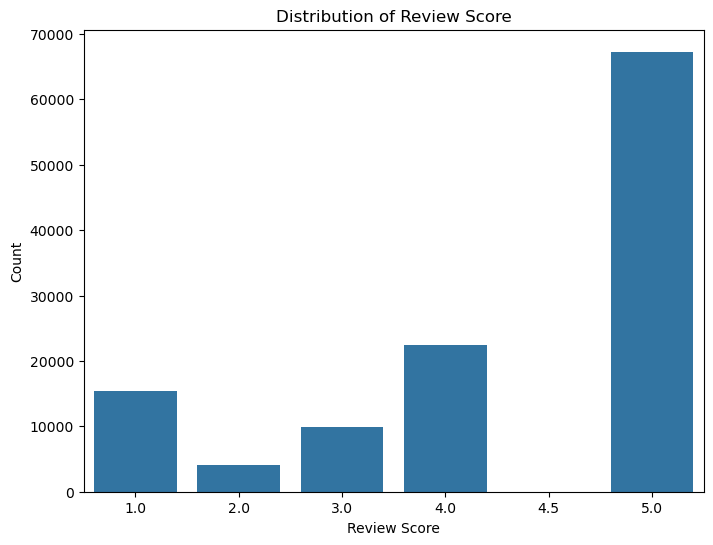

In [108]:
# Get counts of 'Satisfied' and 'Not Satisfied' reviews
review_score_distribution = ecommerce_no_review_data_df['review_score'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=review_score_distribution.index, y=review_score_distribution.values)
plt.title('Distribution of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Count')
# plt.xticks(ticks=range(len(decoded_review_score)), labels=decoded_review_score)
plt.show()

/tmp/ipykernel_645/3123916486.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='review_score', y='product_category_name', data=top_categories, palette='viridis')
/tmp/ipykernel_645/3123916486.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='review_score', y='product_category_name', data=bottom_categories, palette='magma')


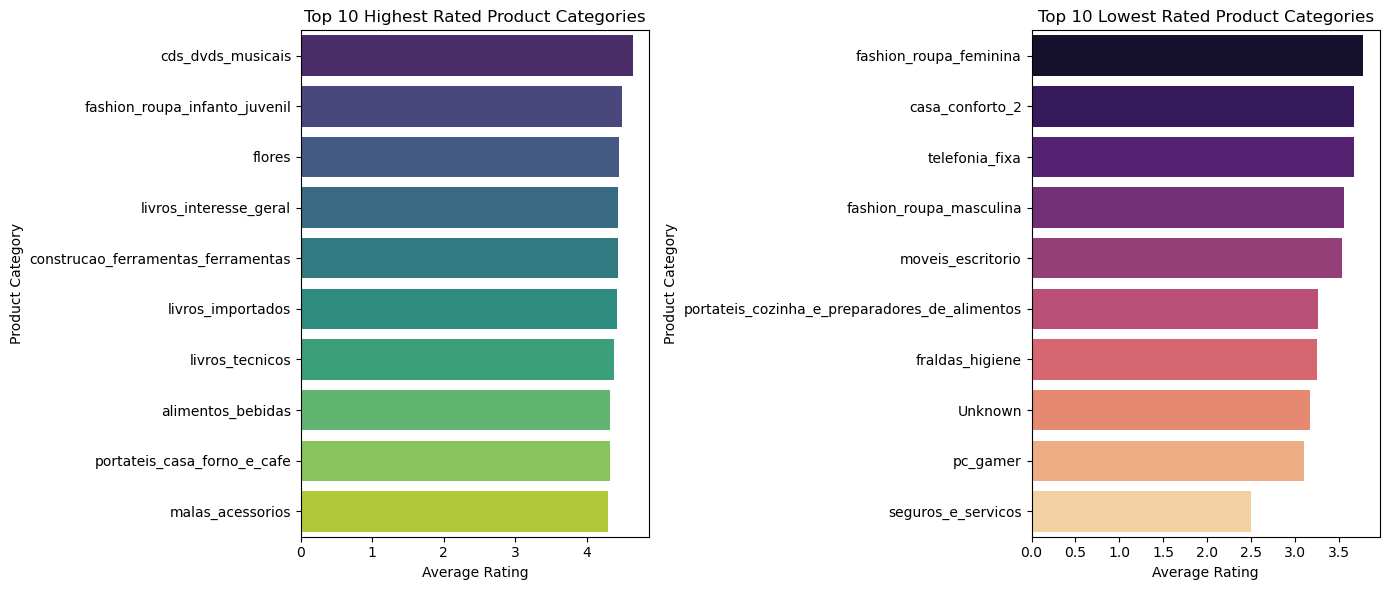

In [109]:
# Calculate the average rating for each product category
category_ratings = ecommerce_no_review_data_df.groupby('product_category_name')['review_score'].mean().reset_index()

# Sort the categories by rating
sorted_category_ratings = category_ratings.sort_values(by='review_score', ascending=False)

# Top 10 highest rated categories
top_categories = sorted_category_ratings.head(10)

# Bottom 10 lowest rated categories
bottom_categories = sorted_category_ratings.tail(10)

# Plotting
plt.figure(figsize=(14, 6))

# Highest Rated Categories
plt.subplot(1, 2, 1)
sns.barplot(x='review_score', y='product_category_name', data=top_categories, palette='viridis')
plt.title('Top 10 Highest Rated Product Categories')
plt.xlabel('Average Rating')
plt.ylabel('Product Category')

# Lowest Rated Categories
plt.subplot(1, 2, 2)
sns.barplot(x='review_score', y='product_category_name', data=bottom_categories, palette='magma')
plt.title('Top 10 Lowest Rated Product Categories')
plt.xlabel('Average Rating')
plt.ylabel('Product Category')

plt.tight_layout()
plt.show()

In [110]:
# Convert review_score to binary classification
ecommerce_no_review_data_df['review_score'] = ecommerce_no_review_data_df['review_score'].apply(lambda x: 1 if int(x) >= 4 else 0)

review_score_distribution = ecommerce_no_review_data_df['review_score'].value_counts()

In [111]:
print(review_score_distribution)

1    89659
0    29484
Name: review_score, dtype: int64


In [112]:
# Identify categorical features
categorical_features = [
    'order_status', 'payment_type', 'product_category_name', # 'review_score'
]

# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    ecommerce_no_review_data_df[col] = le.fit_transform(ecommerce_no_review_data_df[col])
    label_encoders[col] = le

ecommerce_no_review_data_df.head(5)

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,3,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,1.0,...,18.12,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,3,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,3.0,...,2.00,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,3,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,2.0,...,18.59,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,3,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-21 20:05:16,29.99,7.78,1.0,...,37.77,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,3,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-08 18:37:31,29.99,7.78,1.0,...,37.77,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [113]:
ecommerce_no_review_data_df.isnull().sum()

order_status                        0
order_purchase_timestamp            0
order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_estimated_delivery_date       0
shipping_limit_date               833
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
review_score                        0
product_category_name               0
product_name_lenght              2542
product_description_lenght       2542
product_photos_qty               2542
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
dtype: int64

In [114]:
ecommerce_no_review_data_df.describe(include='all')

/tmp/ipykernel_645/3502244706.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ecommerce_no_review_data_df.describe(include='all')


,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,119143.000000,119143,118966,117057,115722,119143,118310,119143.000000,119143.000000,119143.000000,...,119143.000000,119143.000000,119143.000000,116601.000000,116601.000000,116601.000000,119143.000000,119143.000000,119143.000000,119143.000000
unique,NaN,98875,90733,81018,95664,459,93318,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,2017-08-14 20:43:31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,63,63,63,63,663,63,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00,2016-09-19 00:15:34,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00,2020-04-09 22:35:08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.050293,NaN,NaN,NaN,NaN,NaN,NaN,120.292433,19.998810,1.094735,...,172.733437,0.752533,36.949909,48.767498,785.967822,2.205161,2100.352014,30.191736,16.586656,23.017072
std,0.470269,NaN,NaN,NaN,NaN,NaN,NaN,183.513493,15.786463,0.730132,...,267.772919,0.431542,22.532654,10.033540,652.584121,1.717452,3775.716264,16.154482,13.410988,11.726761
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.850000,0.000000,1.000000,...,0.000000,0.000000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,39.900000,13.080000,1.000000,...,60.850000,1.000000,14.000000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000


In [115]:
# Identify numerical columns excluding encoded categorical columns
encoded_categorical_columns = [f for f in categorical_features]
numerical_columns = ecommerce_no_review_data_df.select_dtypes(include=['number']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in encoded_categorical_columns + ['review_score']]

# Print the identified numerical columns
print("Numerical columns identified:")
print(numerical_columns)

Numerical columns identified:
['price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


In [116]:
# Decode categorical labels for other categorical features
decoded_categories = {}
for col in categorical_features:
    decoded_categories[col] = label_encoders[col].inverse_transform(ecommerce_no_review_data_df[col].unique())

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


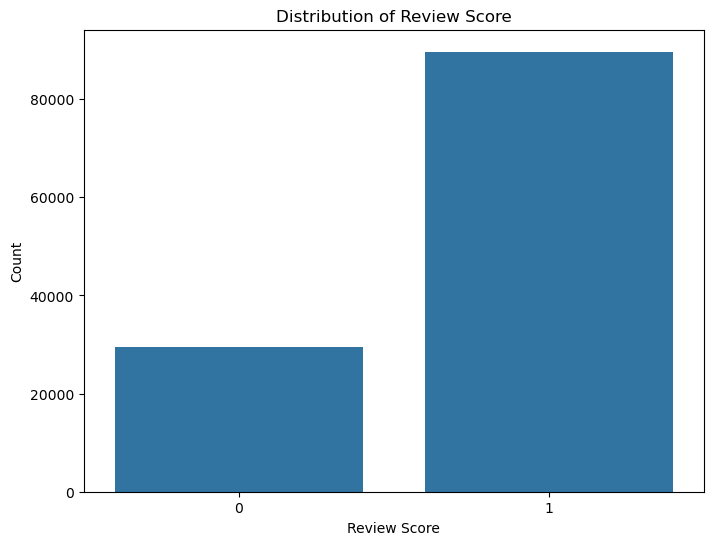

In [117]:
# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=review_score_distribution.index, y=review_score_distribution.values)
plt.title('Distribution of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

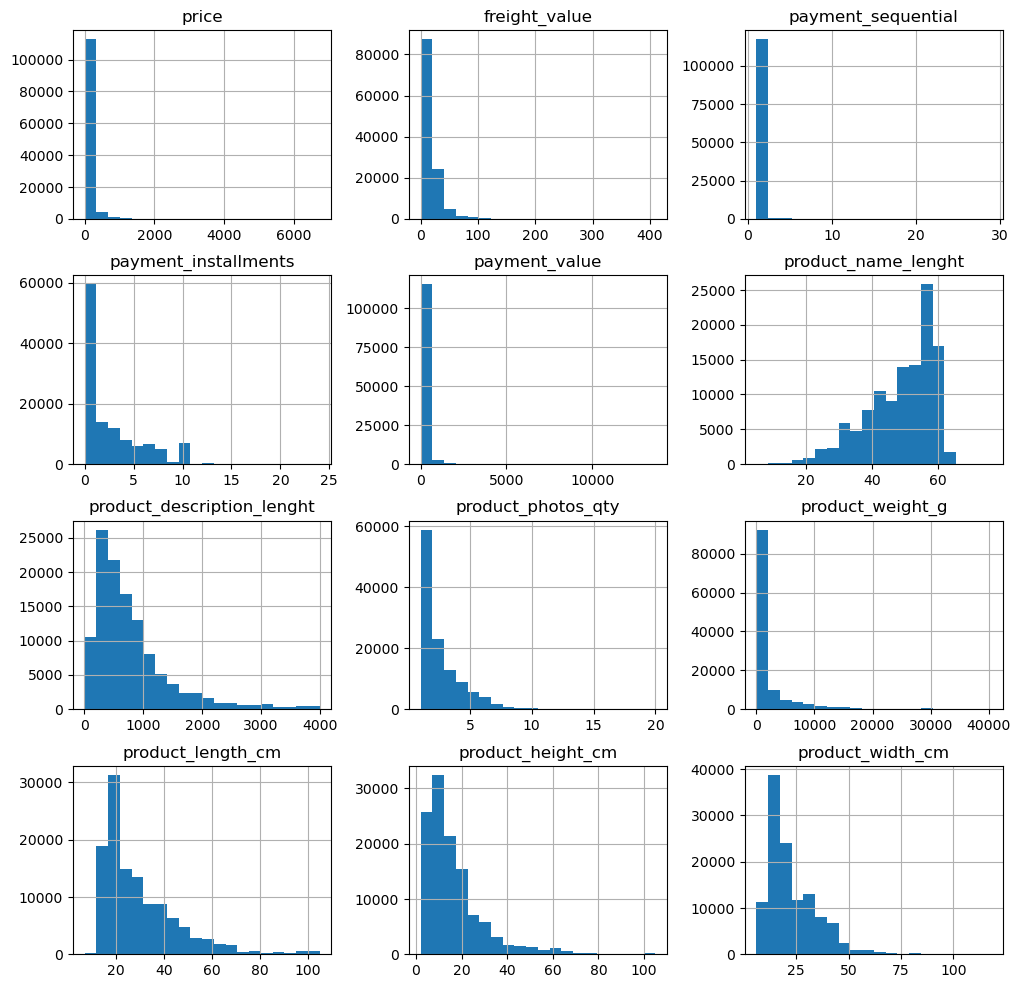

In [118]:
ecommerce_no_review_data_df[numerical_columns].hist(figsize=(12,12),bins=20)
plt.show()

In [119]:
# Calculate skewness
skewness = ecommerce_no_review_data_df[numerical_columns].apply(stats.skew)

# Interpretation
print("Skewness:")
print(skewness)

# Quick analysis
for col, skew_val in skewness.items():
    if abs(skew_val) > 1:
        print(f"{col} is highly skewed (Skewness: {skew_val})")
    elif abs(skew_val) > 0.5:
        print(f"{col} is moderately skewed (Skewness: {skew_val})")
    else:
        print(f"{col} is approximately symmetric (Skewness: {skew_val})")

Skewness:
price                          7.919568
freight_value                  5.563618
payment_sequential            15.775506
payment_installments           1.619837
payment_value                 13.965974
product_name_lenght                 NaN
product_description_lenght          NaN
product_photos_qty                  NaN
product_weight_g               3.597359
product_length_cm              1.756215
product_height_cm              2.251254
product_width_cm               1.717082
dtype: float64
price is highly skewed (Skewness: 7.919568237135088)
freight_value is highly skewed (Skewness: 5.563617722012105)
payment_sequential is highly skewed (Skewness: 15.775505871622283)
payment_installments is highly skewed (Skewness: 1.6198374666647348)
payment_value is highly skewed (Skewness: 13.965973670979409)
product_name_lenght is approximately symmetric (Skewness: nan)
product_description_lenght is approximately symmetric (Skewness: nan)
product_photos_qty is approximately symmetric (Ske

Highly skewed features such as price, freight_value, payment_sequential, payment_installments, and payment_value indicate that most data points are clustered towards lower values, with a long tail extending towards higher values. This suggests that while the majority of transactions or payments involve lower amounts, there are some instances of significantly higher values, contributing to the positive skewness. Similarly, dimension-related features like product_weight_g, product_length_cm, product_height_cm, and product_width_cm exhibit positive skewness, indicating that most products have smaller dimensions, but there are some outliers with larger dimensions. Features labeled as approximately symmetric, such as product_name_length, product_description_length, and product_photos_qty, have relatively balanced distributions without significant skewness. However, further investigation is warranted for features with 'nan' skewness coefficients to assess their variability. 

There is a Severe Imbalance Between the Reviews

In [120]:
# print(decoded_categories['review_score'])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


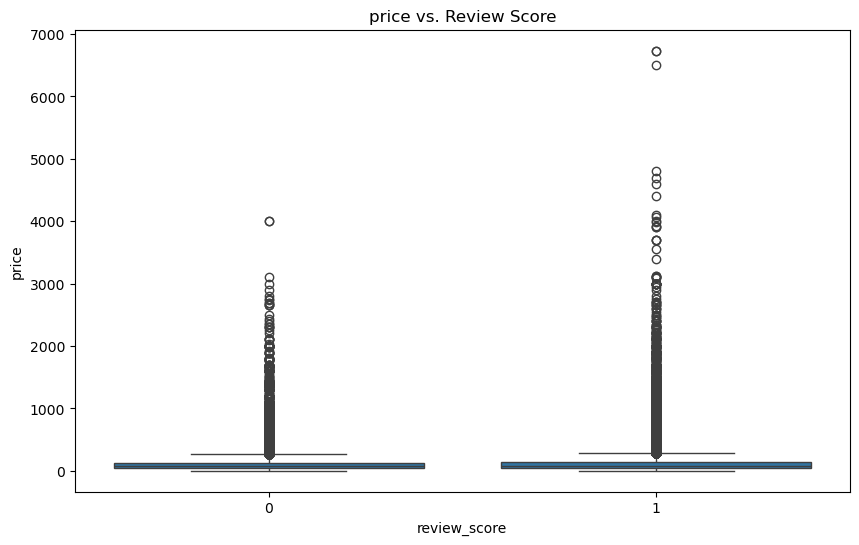

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


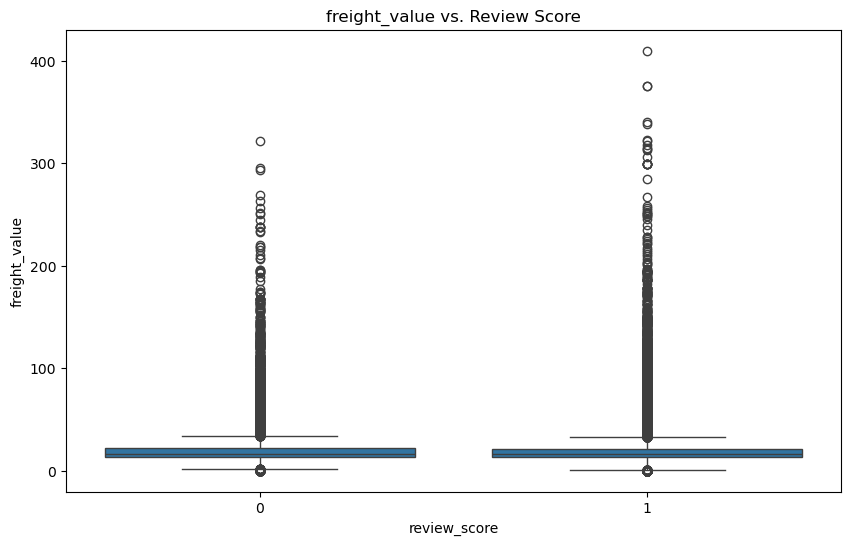

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


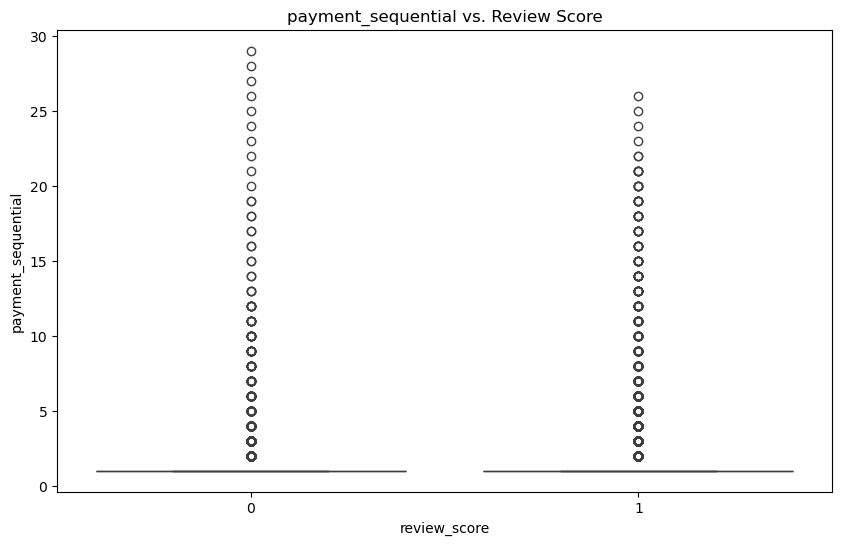

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


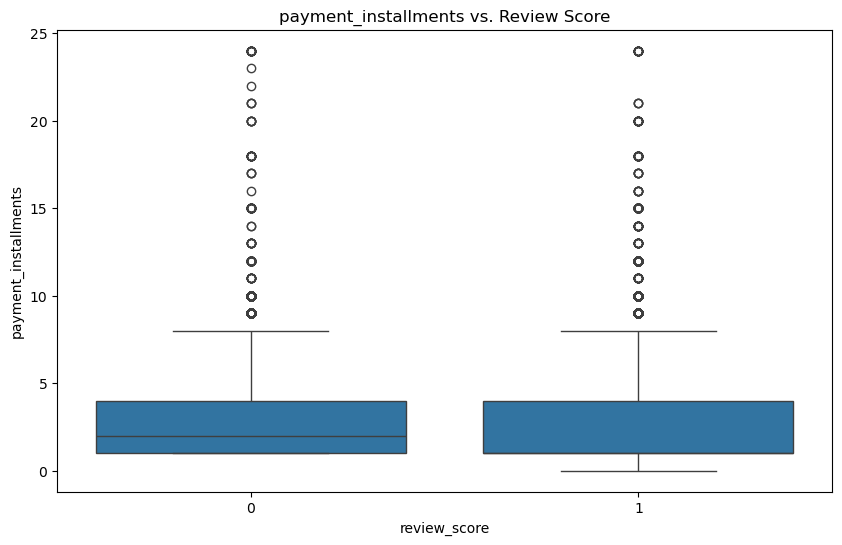

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


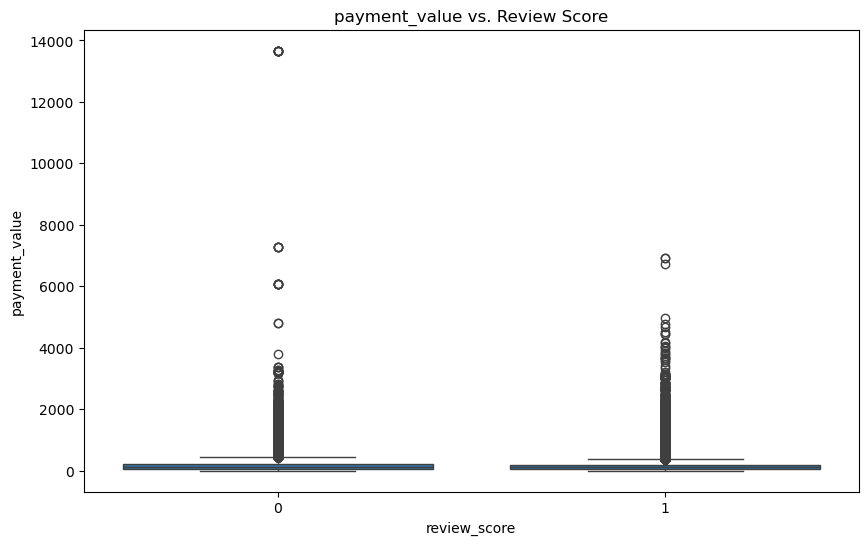

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


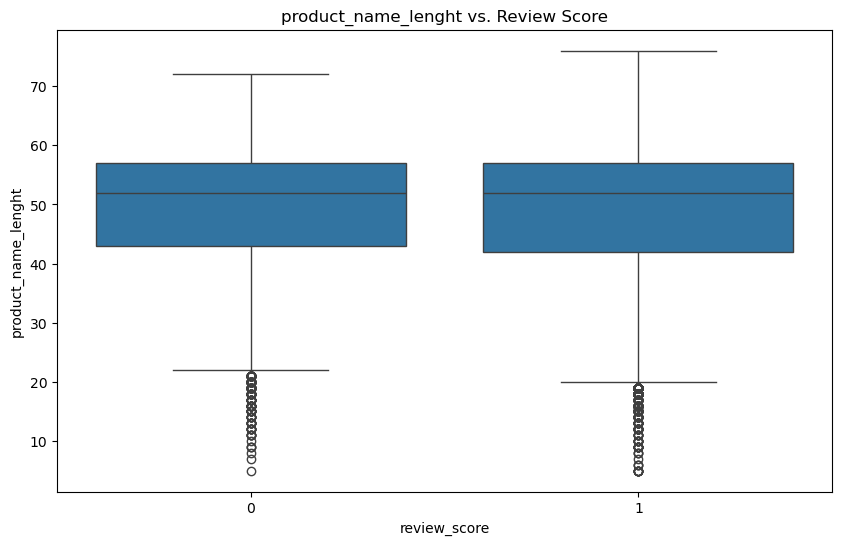

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


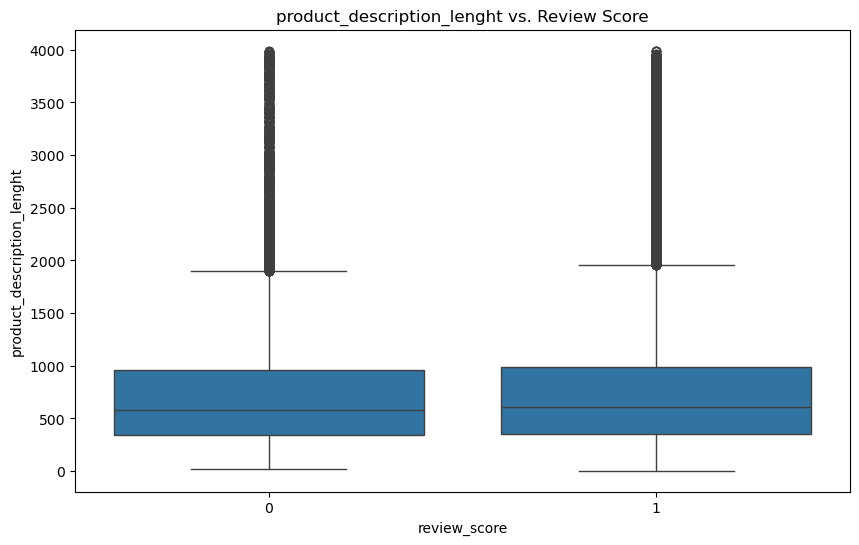

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


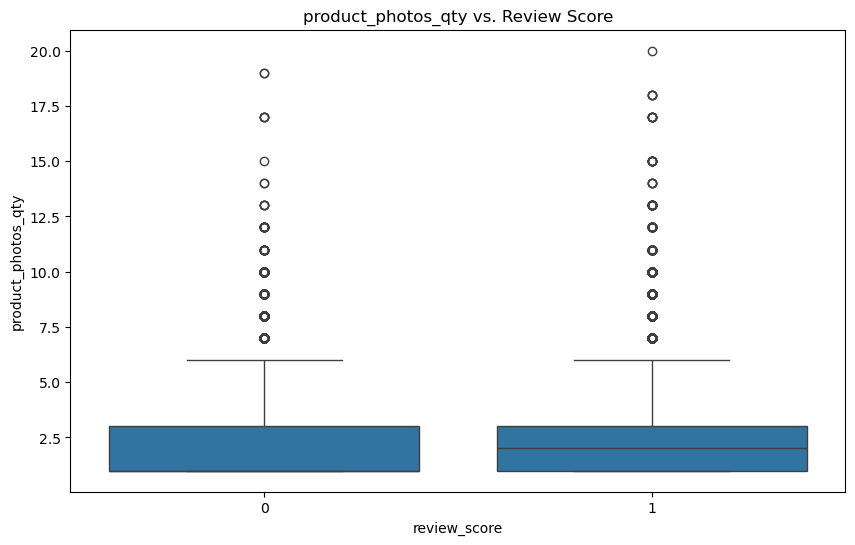

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


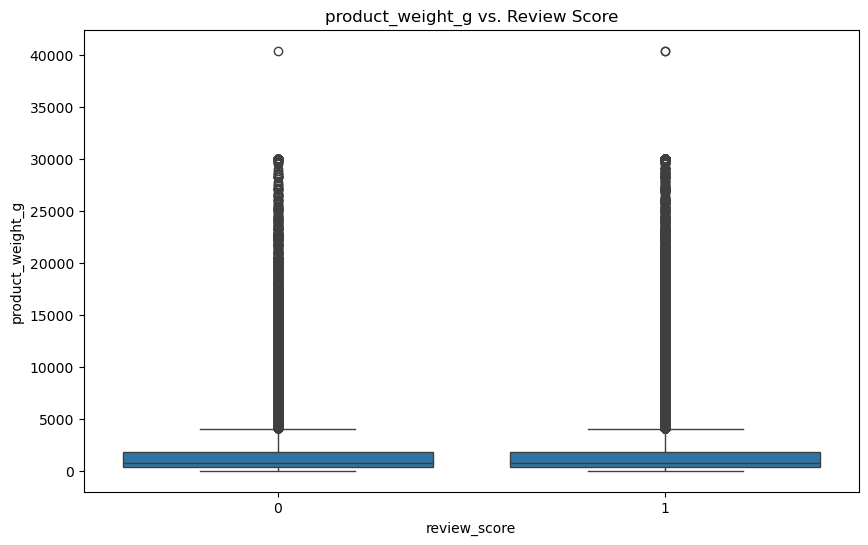

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


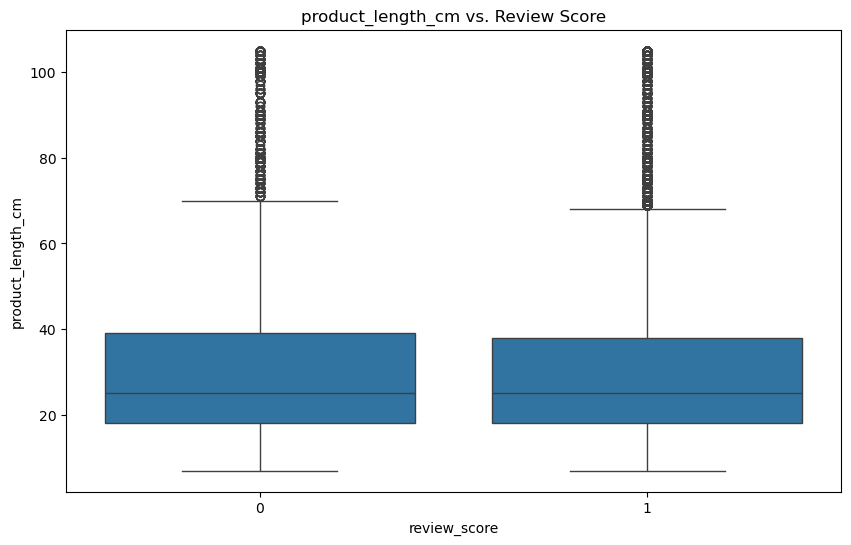

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


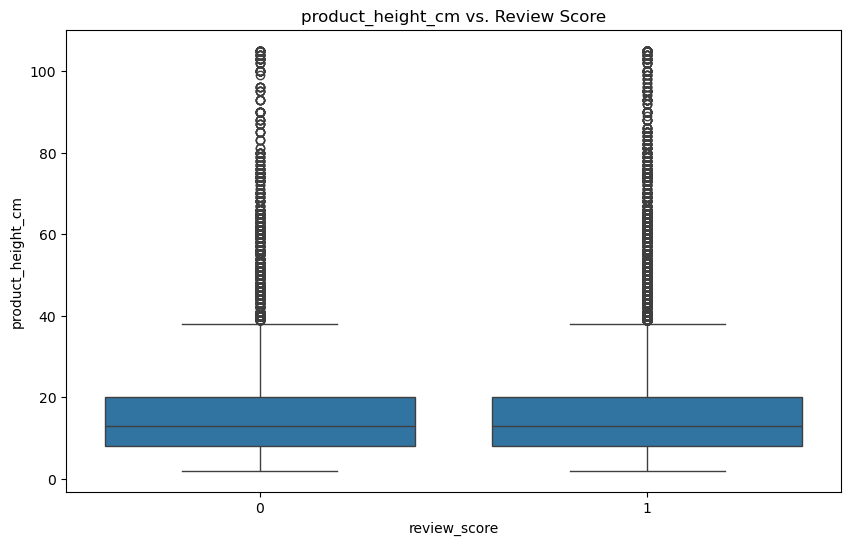

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


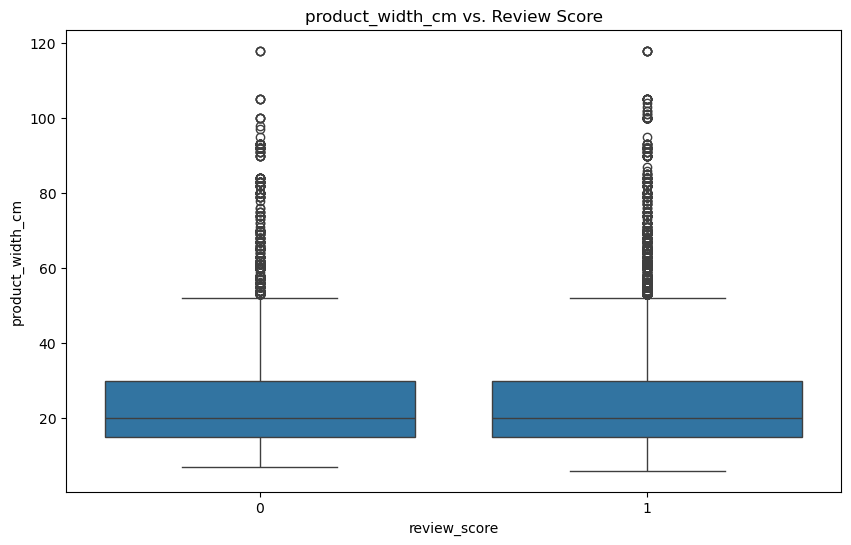

In [121]:
# Box plot for numerical features vs. review score
for feature in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='review_score', y=feature, data=ecommerce_no_review_data_df)
    plt.title(f'{feature} vs. Review Score')
    plt.show()

/opt/conda/lib/python3.8/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


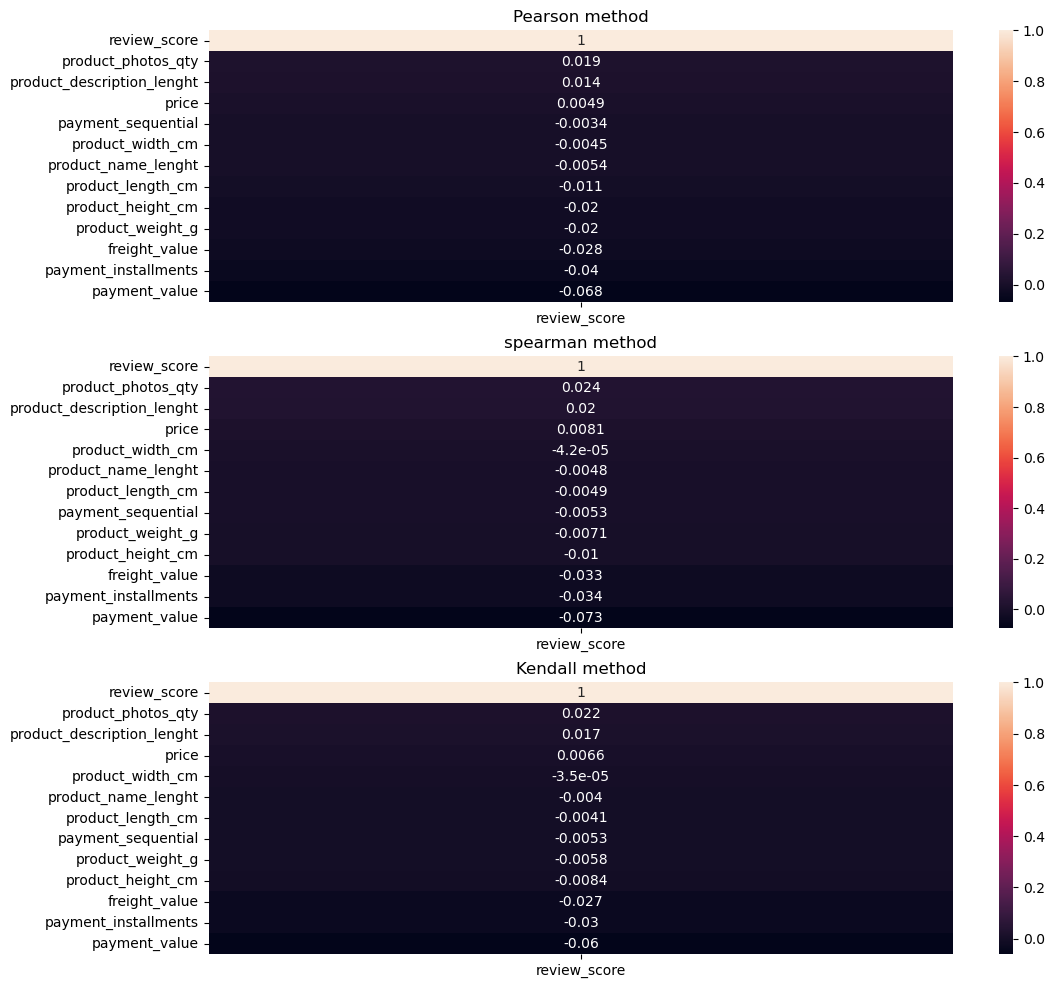

In [122]:
fig, ax = plt.subplots(3,1, figsize=(12, 12))
## Correlation coefficient using different methods
corr1 = ecommerce_no_review_data_df[numerical_columns + ['review_score']].corr('pearson')[['review_score']].sort_values(by='review_score', ascending=False)
corr2 = ecommerce_no_review_data_df[numerical_columns + ['review_score']].corr('spearman')[['review_score']].sort_values(by='review_score', ascending=False)
corr3 = ecommerce_no_review_data_df[numerical_columns + ['review_score']].corr('kendall')[['review_score']].sort_values(by='review_score', ascending=False)

#setting titles for each plot
ax[0].set_title('Pearson method')
ax[1].set_title('spearman method')
ax[2].set_title('Kendall method')
## Generating heatmaps of each methods
sns.heatmap(corr1, ax=ax[0], annot=True)
sns.heatmap(corr2, ax=ax[1], annot=True)
sns.heatmap(corr3, ax=ax[2], annot=True)

plt.show()

It becomes apparent that non of the numerical feautres have a strong enough correlation to impact review_score

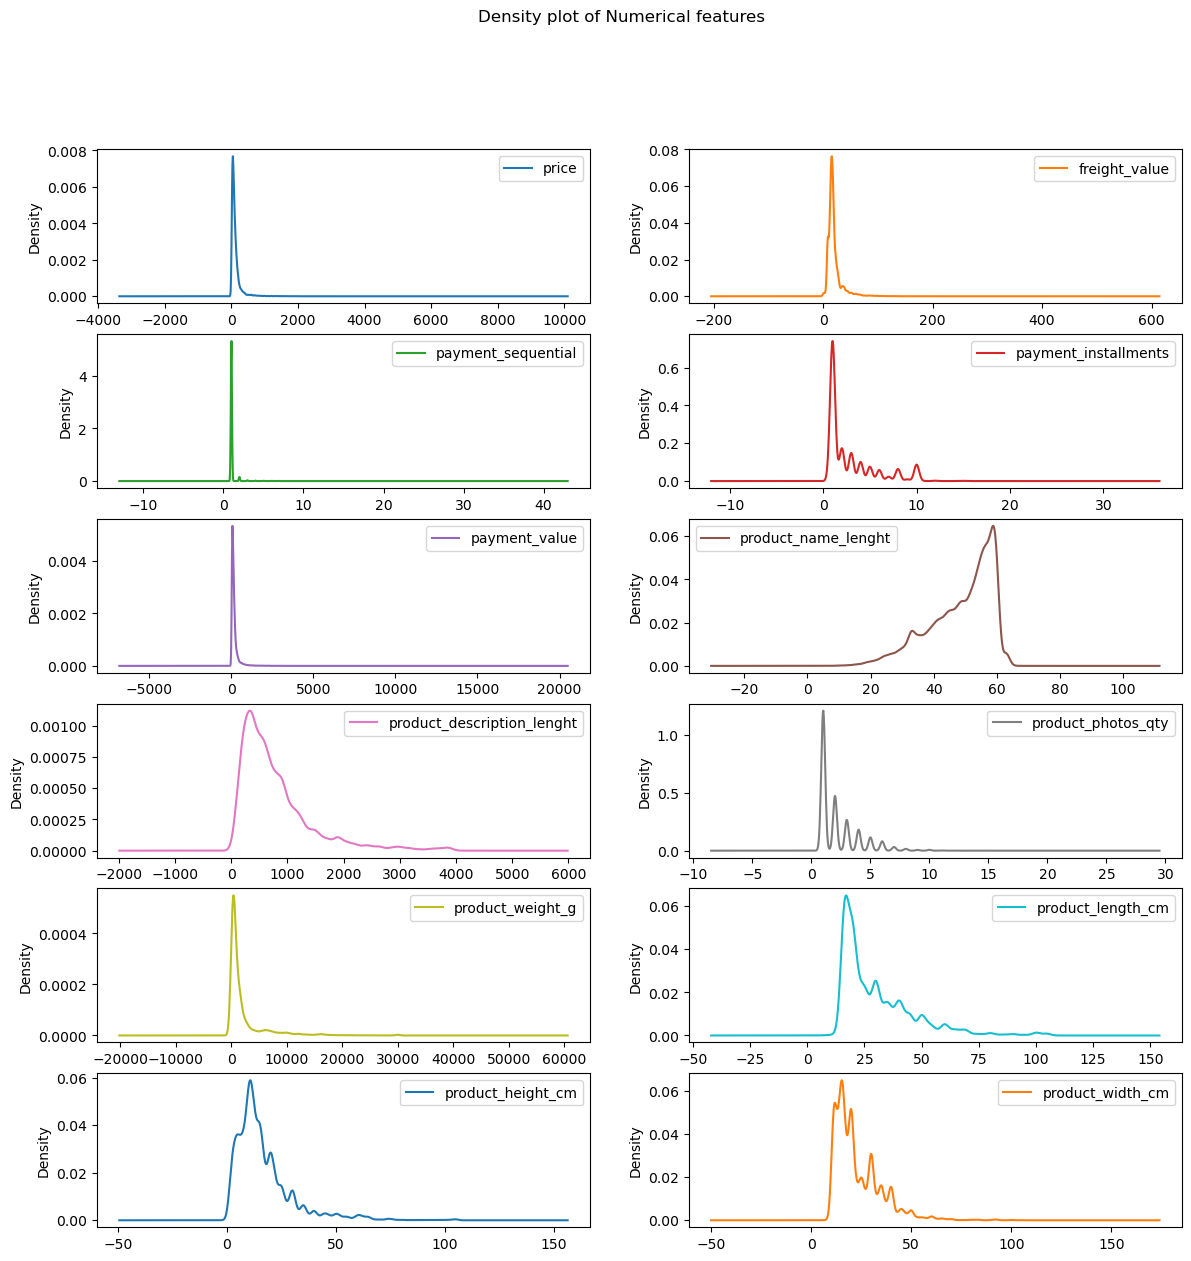

In [123]:
ecommerce_no_review_data_df[numerical_columns].plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

There is an Imbalance Not only in the Review Distribution but in the Numerical Feature Distributions as well

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


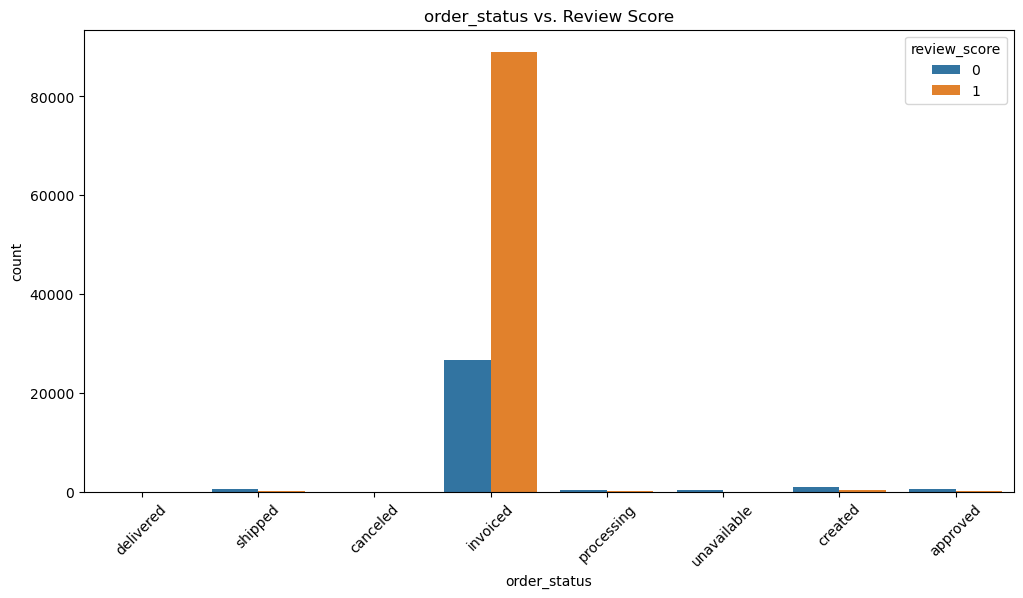

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


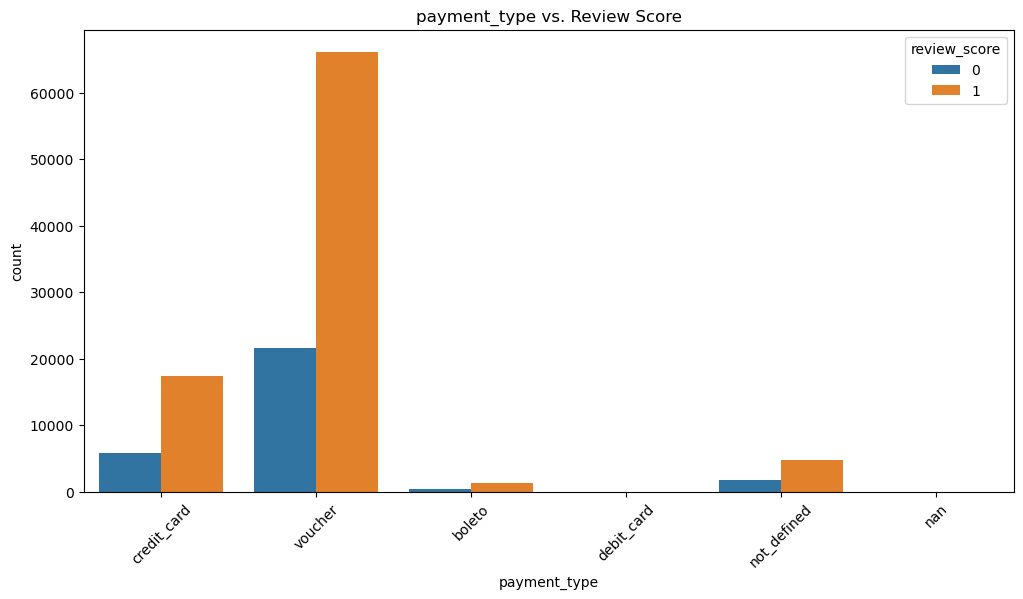

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


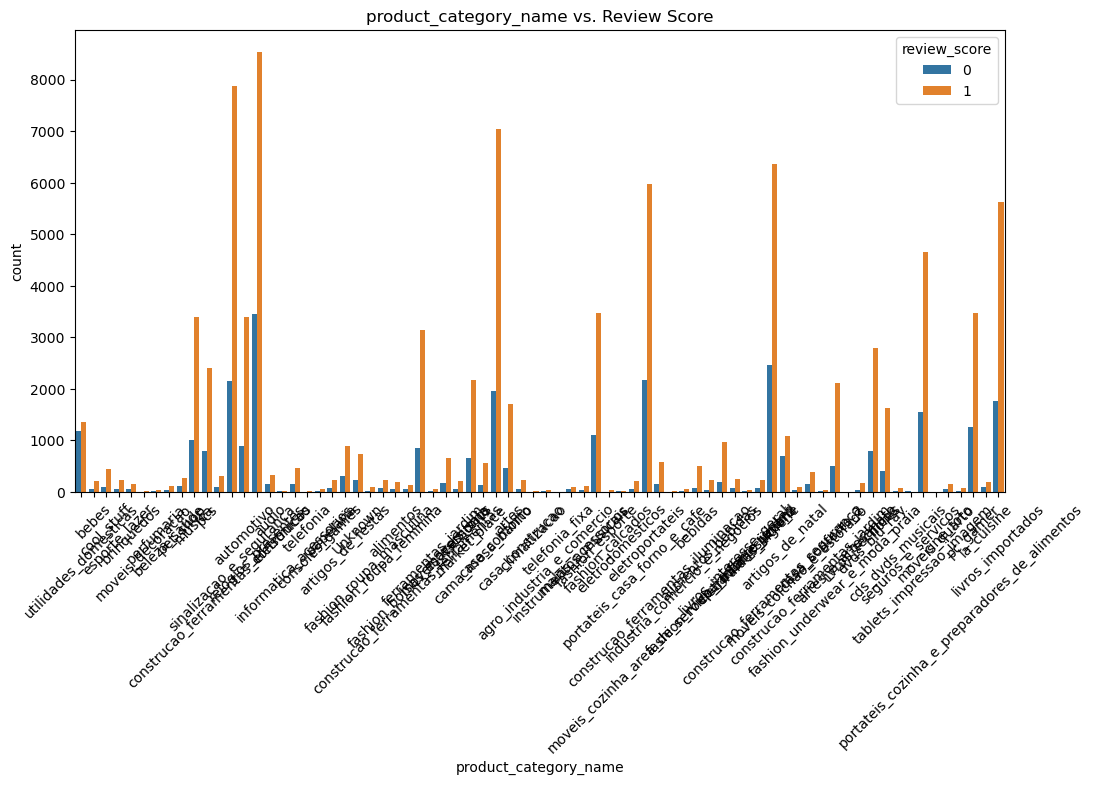

In [124]:
# Bar plot for categorical features vs. review score
for feature in categorical_features:
    if feature == 'review_score':
        continue
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, hue='review_score', data=ecommerce_no_review_data_df)
    plt.title(f'{feature} vs. Review Score')
    # Decode x-axis labels for other categorical features
    plt.xticks(ticks=range(len(decoded_categories[feature])), labels=decoded_categories[feature], rotation=45)
    plt.show()

## Feature Engineering ##

In [125]:
# Create is_late feature
ecommerce_no_review_data_df['is_late'] = (ecommerce_no_review_data_df['order_delivered_customer_date'] > ecommerce_no_review_data_df['order_estimated_delivery_date']).astype(int)

# Create seller_response_time feature in hours
ecommerce_no_review_data_df['seller_response_time'] = (ecommerce_no_review_data_df['order_approved_at'] - ecommerce_no_review_data_df['order_purchase_timestamp']).dt.total_seconds() / 3600

# Check the new features
print(ecommerce_no_review_data_df[['is_late', 'seller_response_time']].head())

   is_late  seller_response_time
0        0              0.178333
1        0              0.178333
2        0              0.178333
3        0              1.595833
4        0              0.307778


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


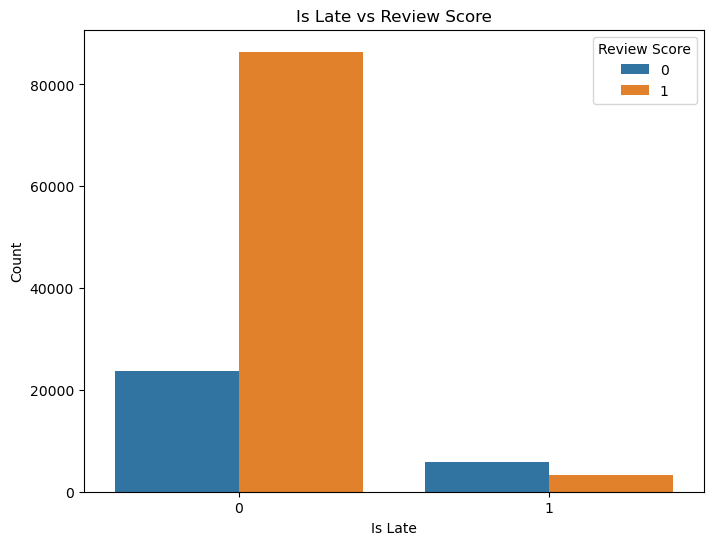

In [126]:
# Distribution of is_late
plt.figure(figsize=(8, 6))
sns.countplot(x='is_late', hue='review_score', data=ecommerce_no_review_data_df)
plt.title('Is Late vs Review Score')
plt.xlabel('Is Late')
plt.ylabel('Count')
plt.legend(title='Review Score')
plt.show()

Even with the Imbalance in 'Satisfied' (1) and 'Not Satsified' (0), If a Delivery is Late it is More Likely to have a negative review

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


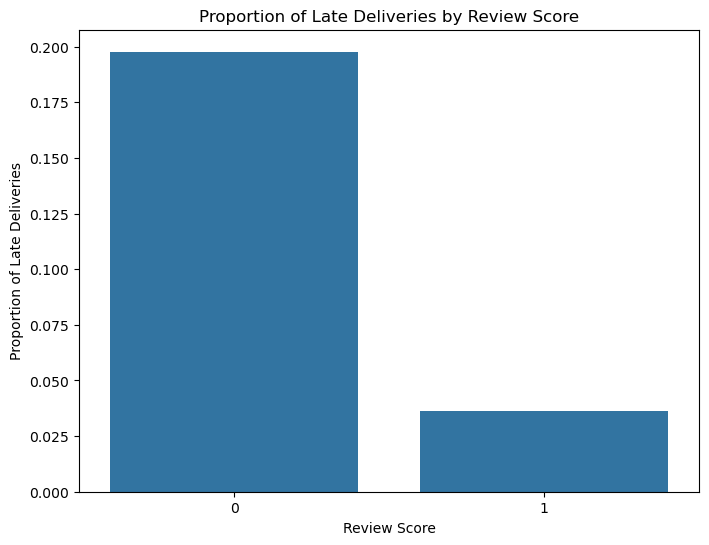

In [127]:
# Proportion of late deliveries by review score
late_review_prop = ecommerce_no_review_data_df.groupby('review_score')['is_late'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='review_score', y='is_late', data=late_review_prop)
plt.title('Proportion of Late Deliveries by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Proportion of Late Deliveries')
plt.show()

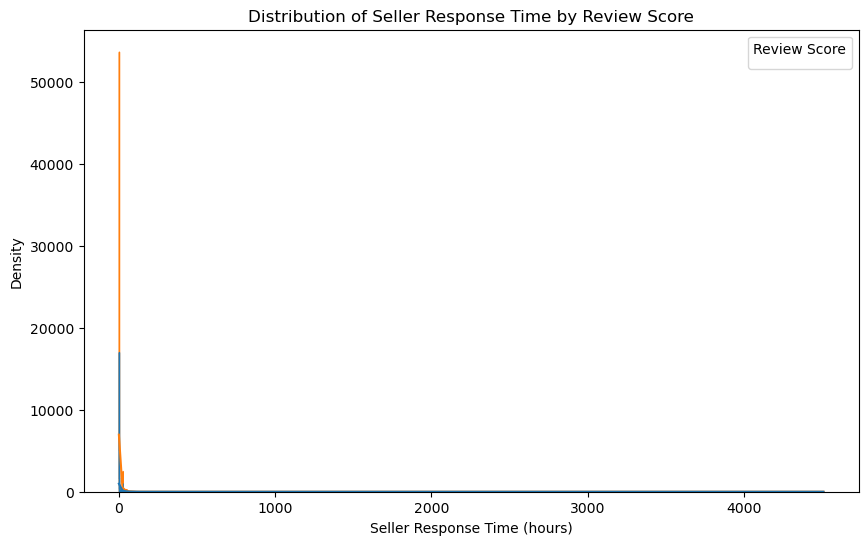

In [128]:
# Distribution of seller_response_time
plt.figure(figsize=(10, 6))
sns.histplot(ecommerce_no_review_data_df, x='seller_response_time', hue='review_score', kde=True, element='step')
plt.title('Distribution of Seller Response Time by Review Score')
plt.xlabel('Seller Response Time (hours)')
plt.ylabel('Density')
plt.legend(title='Review Score')
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


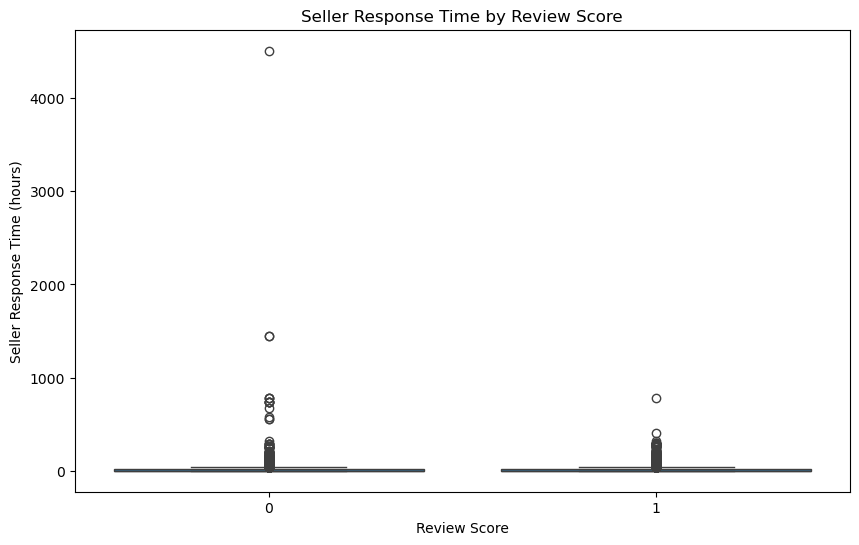

In [129]:
# Boxplot of seller_response_time by review_score
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='seller_response_time', data=ecommerce_no_review_data_df)
plt.title('Seller Response Time by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Seller Response Time (hours)')
plt.show()

In [172]:
# Drop Datetime Stamps
ecommerce_no_date_data_df = ecommerce_no_review_data_df.drop(columns=[col for col in datetime_columns if 'review' not in col])

ecommerce_no_date_data_df.head(5)

,order_status,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,is_late,seller_response_time
0,3,29.99,8.72,1.0,1,1.0,18.12,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,0,0.178333
1,3,29.99,8.72,3.0,4,1.0,2.00,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,0,0.178333
2,3,29.99,8.72,2.0,4,1.0,18.59,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,0,0.178333
3,3,29.99,7.78,1.0,1,3.0,37.77,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,0,1.595833
4,3,29.99,7.78,1.0,1,1.0,37.77,1,73,40.0,268.0,4.0,500.0,19.0,8.0,13.0,0,0.307778


## Perform Data Split ##

In [173]:
# Define features (X) and target variable (y)
X = ecommerce_no_date_data_df.drop(columns=['review_score'])
y = ecommerce_no_date_data_df['review_score']

# Split the data into training (40%), test (10%), validation (10%), and production (40%) datasets
X_train_val, X_production, y_train_val, y_production = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Production set shape:", X_production.shape, y_production.shape)

Train set shape: (53613, 17) (53613,)
Test set shape: (8936, 17) (8936,)
Validation set shape: (8936, 17) (8936,)
Production set shape: (47658, 17) (47658,)


## Benchmark XGBoost Model ##

In [174]:
# Merge features and target variable for training and validation sets
train_data = pd.concat([y_train, X_train], axis=1)
val_data = pd.concat([y_val, X_val], axis=1)

In [175]:
# Upload Split Data into S3
train_file = "train_data.csv"
train_data.to_csv(train_file, index=False, header=False)
sess.upload_data(train_file, key_prefix="{}/data/train".format(prefix))

validation_file = "validation_data.csv"
val_data.to_csv(validation_file, index=False, header=False)
sess.upload_data(validation_file, key_prefix="{}/data/validation".format(prefix))

batch_file = "batch_data.csv"
X_test.to_csv(batch_file, index=False, header=False)
sess.upload_data(batch_file, key_prefix="{}/data/batch".format(prefix))

prod_file = "prod_data.csv"
X_production.to_csv(prod_file, index=False, header=False)
sess.upload_data(prod_file, key_prefix="{}/data/prod".format(prefix))

's3://sagemaker-us-east-1-757088774357/olist_review_score/data/prod/prod_data.csv'

In [188]:
job_name = 'benchmark-xgboost-review-score-prediction-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)
image = sagemaker.image_uris.retrieve(
    framework="xgboost", region=boto3.Session().region_name, version="1.7-1"
)

eval_metrics = 'auc,aucpr,f1,precision,recall'

sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size=50,
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sess,
)

sm_estimator.set_hyperparameters(
    objective= 'binary:logistic',  # Binary classification
    max_depth= 5,  # Maximum depth of each tree
    eta= 0.2,  # Learning rate
    gamma= 4,  # Minimum loss reduction required to make a further partition on a leaf node
    subsample= 0.8,  # Subsample ratio of the training instances
    colsample_bytree= 0.8,  # Subsample ratio of columns when constructing each tree
    eval_metric= eval_metrics,  # Evaluation metric
    alpha= 0.1,  # L1 regularization term
    num_round=100
)

train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/data/train".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/data/validation".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

# Start training by calling the fit method in the estimator
sm_estimator.fit(inputs=data_channels, job_name=job_name, logs=True)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: benchmark-xgboost-review-score-prediction-2024-06-01-02-31-45


2024-06-01 02:31:46 Starting - Starting the training job...
2024-06-01 02:32:01 Starting - Preparing the instances for training...
2024-06-01 02:32:26 Downloading - Downloading input data...
2024-06-01 02:32:55 Downloading - Downloading the training image...
2024-06-01 02:33:31 Training - Training image download completed. Training in progress..[2024-06-01 02:33:42.379 ip-10-2-225-116.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-01 02:33:42.403 ip-10-2-225-116.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-01:02:33:42:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-01:02:33:42:INFO] Failed to parse hyperparameter eval_metric value auc,aucpr,f1,precision,recall to Json.
Returning the value itself
[2024-06-01:02:33:42:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2024-06-01:02:33:42:INFO] No GPUs detected (normal if no gpus installed

### Benchmark Results on Batch Data ###

In [189]:
# Create the transformer object
transformer = sm_estimator.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

# Specify the S3 URI of the test data
test_data_s3_uri = "s3://{}/{}/data/batch/{}".format(bucket, prefix, batch_file)

transformer.transform(
    test_data_s3_uri,
    split_type="Line",
    content_type="text/csv",
)

# Wait for the job to complete
transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-06-01-02-34-32-933
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-06-01-02-34-33-659


..................................[2024-06-01:02:40:18:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-01:02:40:18:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-01:02:40:18:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-06-01 02:40:18 +0000] [19] [INFO] Starting g

In [197]:
# Initialize Boto3 S3 client
s3_client = boto3.client('s3')

def get_csv_output_from_s3(s3uri, batch_file):
    file_name = "{}.out".format(batch_file)
    match = re.match("s3://([^/]+)/(.*)", "{}/{}".format(s3uri, file_name))
    output_bucket, output_prefix = match.group(1), match.group(2)
    print(output_bucket + output_prefix)
    s3_client.download_file(output_bucket, output_prefix, file_name)
    return pd.read_csv(file_name, sep=",", header=None)

In [198]:
batch_out_df = get_csv_output_from_s3(transformer.output_path, batch_file)
batch_out_df

sagemaker-us-east-1-757088774357sagemaker-xgboost-2024-06-01-02-34-33-659/batch_data.csv.out


,0
0,0.828119
1,0.844177
2,0.581795
3,0.817673
4,0.851187
...,...
8931,0.825549
8932,0.494958
8933,0.861903
8934,0.868430


### Batch BenchModel Metrics  ###

In [209]:
def convert_probabilities_to_binary(probabilities, threshold=0.5):
    # Convert probabilities to binary predictions
    binary_predictions = (probabilities >= threshold).astype(int)
    return binary_predictions

def calculate_metrics(y_true, y_prob):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_prob)
    precision = precision_score(y_true, y_prob)
    recall = recall_score(y_true, y_prob)
    f1 = f1_score(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    return accuracy, precision, recall, f1, roc_auc

def print_metrics(accuracy, precision, recall, f1, roc_auc):
    metrics_string = f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}"
    print(metrics_string)


In [210]:
y_prob = convert_probabilities_to_binary(batch_out_df[0])

accuracy_batch, precision_batch, recall_batch, f1_batch, roc_auc_batch = calculate_metrics(y_test, y_prob)

print_metrics(accuracy_batch, precision_batch, recall_batch, f1_batch, roc_auc_batch)

Accuracy: 0.8045, Precision: 0.8141, Recall: 0.9611, F1 Score: 0.8815, ROC AUC: 0.6391


The accuracy metric, which measures the overall correctness of the model's predictions, may appear deceptively high in the presence of class imbalance. In scenarios where the majority class dominates, a model could achieve high accuracy by simply predicting the majority class for every instance, without effectively capturing the nuances of the minority class.

Precision, recall, and F1 score are metrics that focus specifically on the performance of the minority class, making them more informative in imbalanced datasets. Precision reflects the proportion of true positive predictions among all positive predictions made by the model. In this case, the precision of 0.8141 suggests that the model correctly identifies a substantial portion of positive instances but may also produce false positives.

Recall, on the other hand, measures the proportion of true positive predictions among all actual positive instances in the dataset. The high recall value of 0.9611 indicates that the model effectively captures the majority of positive instances present in the data.

The F1 score, which represents the harmonic mean of precision and recall, provides a balanced assessment of the model's ability to correctly identify positive instances while minimizing false positives. The F1 score of 0.8815 suggests that the model achieves a good balance between precision and recall, considering the imbalanced nature of the dataset.

ROC AUC (Receiver Operating Characteristic Area Under the Curve) measures the model's ability to distinguish between the positive and negative classes across various threshold values. However, in imbalanced datasets, ROC AUC may not fully capture the performance of the minority class, as it can be dominated by the majority class. Therefore, the ROC AUC value of 0.6391 should be interpreted with caution, considering the class imbalance.

## Model Optimization ##

In [16]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>